# 1. Importing Libraries

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np,pandas as pd
import os,glob
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten,GlobalAveragePooling2D,Dropout
from tensorflow.keras.models import Sequential

# 2. Loading data

In [51]:
# train directory have different categories of folders of images
train_dir = '/kaggle/input/flowerdataset/FlowerDataset2/Train'
test_dir = '/kaggle/input/flowerdataset/FlowerDataset2/Test'

# 3. Visualizing classes

In [52]:
train_image_names = glob.glob('/kaggle/input/flowerdataset/FlowerDataset2/Train/*/*.jpg')
test_image_names = glob.glob('/kaggle/input/flowerdataset/FlowerDataset2/Test/*/*.jpg')
print("Total number of training images: ", len(train_image_names))
print("Total number of test images: ", len(test_image_names))

## make train_image_names as serie object
train_image_names = pd.Series(train_image_names)

Total number of training images:  1520
Total number of test images:  299


In [4]:
# train_df: a dataframe with 2 field: Filename, ClassId
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate ClassId field
train_df['ClassId'] = train_image_names.map(lambda img_name: int(img_name.split("/")[-2][5:]))

train_df.head()

Filename  ClassId
0  JFT_01266.jpg       26
1  JFT_01255.jpg       26
2  JFT_01270.jpg       26
3  JFT_01273.jpg       26
4  JFT_01263.jpg       26

Text(0.5, 1.0, 'Number of images in each class')

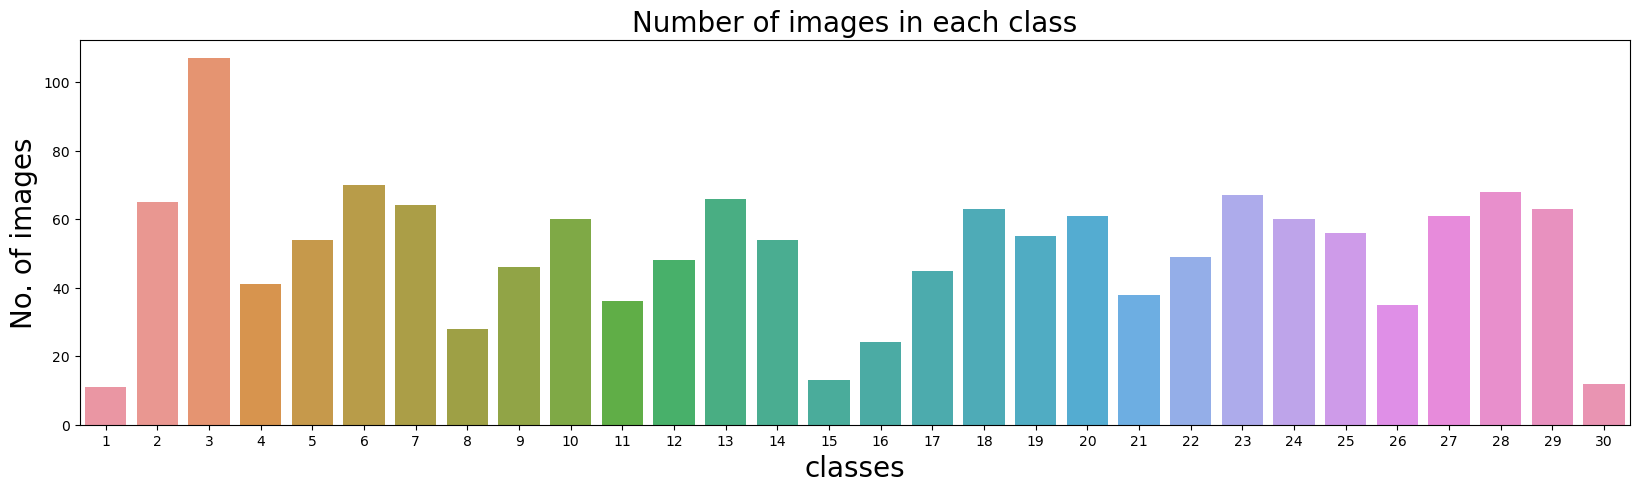

In [5]:
plt.figure(figsize=(20,5))
labels = []
for row in train_df.index:
    labels.append(train_df.ClassId[row])
sns.countplot(x= labels)
plt.xlabel('classes',fontsize=20)
plt.ylabel('No. of images',fontsize=20)
plt.title('Number of images in each class',fontsize=20)

# 4. Balancing classes

In [6]:
y = train_df['ClassId']
x = train_df.drop(columns = ['ClassId'])

In [7]:
# To overcome class imbalace
from imblearn.over_sampling import RandomOverSampler 
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [8]:
print(x.shape,y.shape)

(3210, 1) (3210,)


Text(0.5, 1.0, 'Number of images in each class')

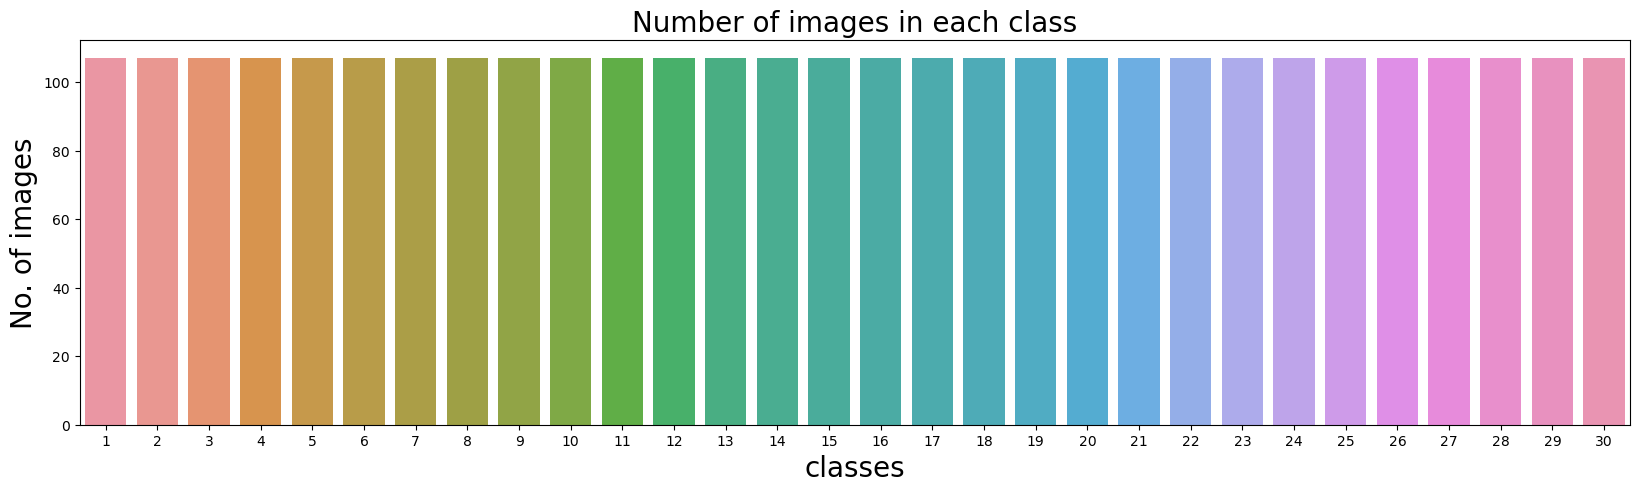

In [9]:
plt.figure(figsize=(20,5))
sns.countplot(x= y)
plt.xlabel('classes',fontsize=20)
plt.ylabel('No. of images',fontsize=20)
plt.title('Number of images in each class',fontsize=20)

# 5. Loading images from directories

In [54]:
def get_train_val_test_ds(img_resize):
    
    img_height,img_width=img_resize,img_resize
    batch_size=32

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      validation_split=0.2,
      subset="training",
      shuffle=True,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
      train_dir,
      validation_split=0.2,
      subset="validation",
      shuffle=True,
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)
    
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
      test_dir,
      image_size=(img_height, img_width),
      shuffle=False,
      batch_size=batch_size)
    
    return train_ds,val_ds,test_ds
    
train_ds , val_ds , test_ds = get_train_val_test_ds(img_resize=224)

Found 1520 files belonging to 30 classes.
Using 1216 files for training.
Found 1520 files belonging to 30 classes.
Using 304 files for validation.
Found 299 files belonging to 30 classes.


In [55]:
class_names = train_ds.class_names
print(class_names)
print()
print(val_ds.class_names)
print()
print(test_ds.class_names)

# check the number of batches in train, test, val ds
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

['Class1', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14', 'Class15', 'Class16', 'Class17', 'Class18', 'Class19', 'Class2', 'Class20', 'Class21', 'Class22', 'Class23', 'Class24', 'Class25', 'Class26', 'Class27', 'Class28', 'Class29', 'Class3', 'Class30', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9']

['Class1', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14', 'Class15', 'Class16', 'Class17', 'Class18', 'Class19', 'Class2', 'Class20', 'Class21', 'Class22', 'Class23', 'Class24', 'Class25', 'Class26', 'Class27', 'Class28', 'Class29', 'Class3', 'Class30', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9']

['Class1', 'Class10', 'Class11', 'Class12', 'Class13', 'Class14', 'Class15', 'Class16', 'Class17', 'Class18', 'Class19', 'Class2', 'Class20', 'Class21', 'Class22', 'Class23', 'Class24', 'Class25', 'Class26', 'Class27', 'Class28', 'Class29', 'Class3', 'Class30', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9']
Number of train batches: 38
Numb

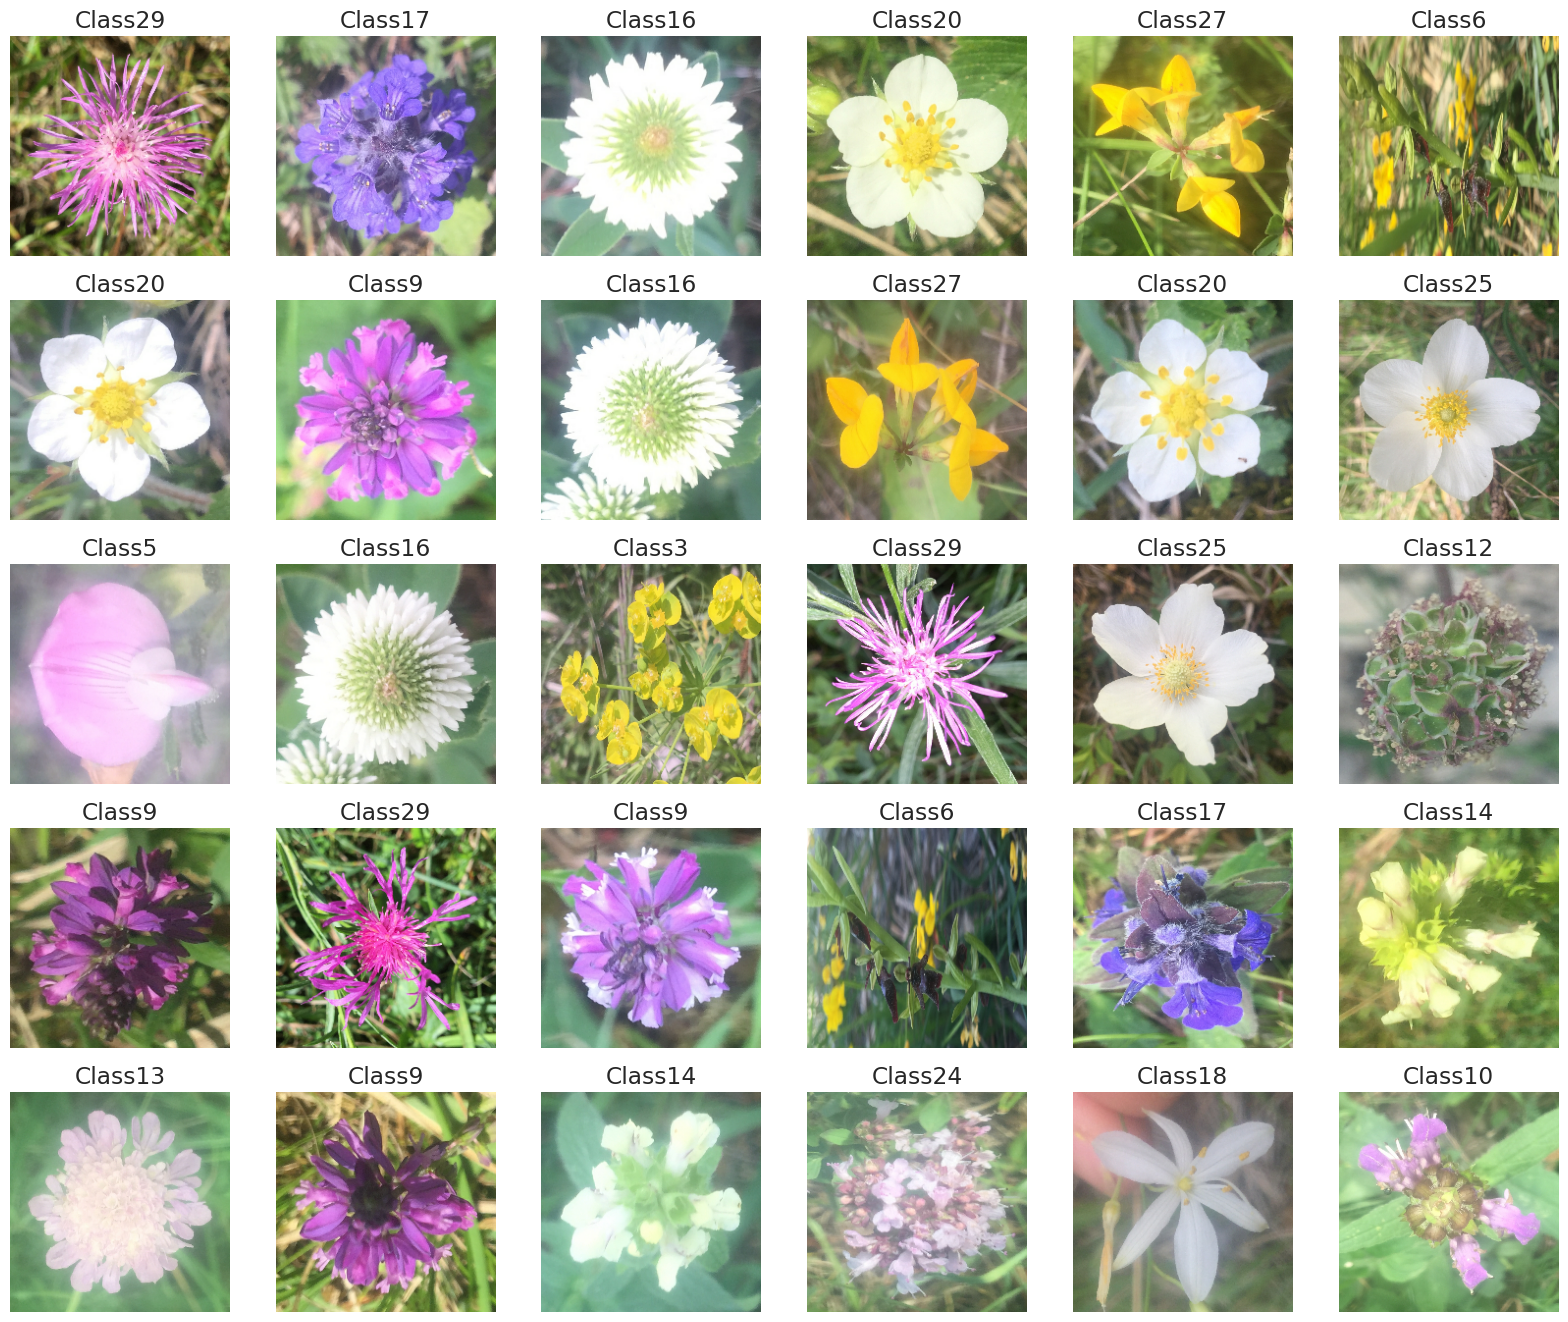

In [56]:
# Showing images from 1 batch in train_ds (1 batch has 32 images with their labels)
plt.figure(figsize=(20, 20))

for images, labels in train_ds.take(1):
    for i in range(30):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [57]:
# function to show accuracy,loss curves
def plot_accuracy_loss():
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))
    ax = ax.ravel()
    fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=25,fontweight='bold',
             fontname='monospace',y=1,x=0.28,alpha=0.8)
        
    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met],label=f'Training {met}')
        ax[i].plot(history.history['val_' + met],label=f'Validation {met}')
        ax[i].set_title('Model {}'.format(met),fontsize = 20)
        ax[i].set_xlabel('epochs',fontsize = 17)
        ax[i].set_ylabel(met,fontsize = 17)
        ax[i].grid()
        ax[i].legend(fontsize = 17)

# 6. Data Augmentation

In [15]:
# Data Augmentation - to avoid overfitting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

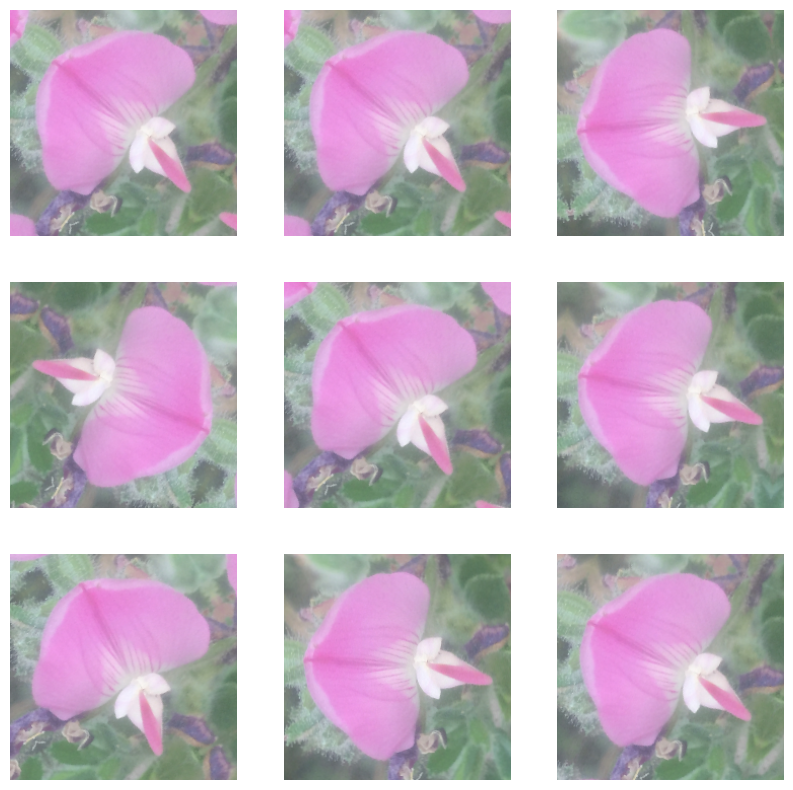

In [16]:
## Showing a single image formed by applying data augmentation
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 7. Using Transfer Learning with 5 models and choosing the one with better accuracy

#### A) *ResNet50*
#### B) *EfficientNetB0*
#### C) *VGG19*
#### D) *DenseNet201*
#### E) *XceptionNet*

### A) ResNet50

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 30)                15390     
                                                       

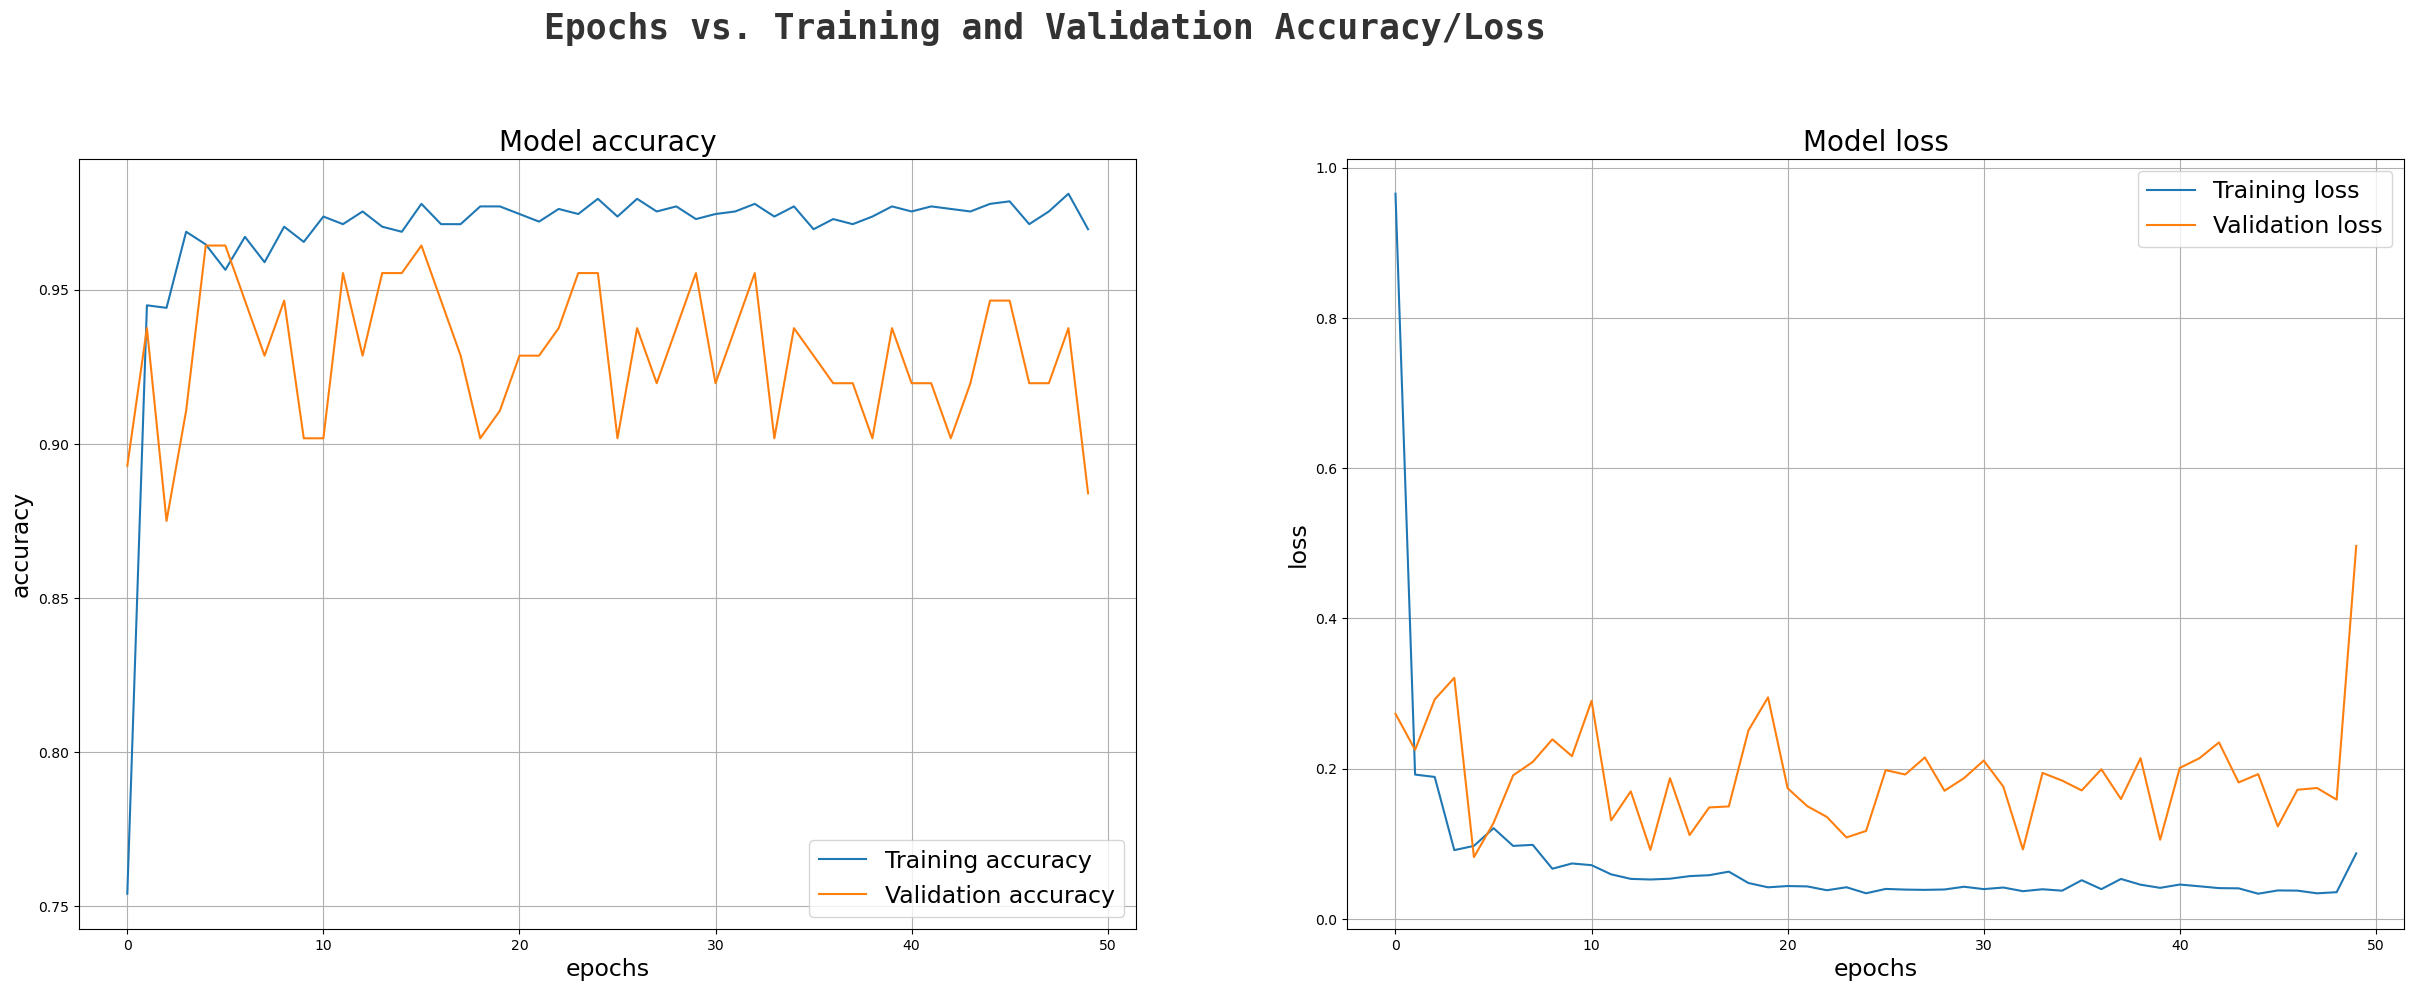

In [17]:
# define model
pretrained_model= tf.keras.applications.ResNet50(
                   include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model = Sequential()
resnet_model.add(tf.keras.Input(shape=(224, 224, 3)))
resnet_model.add(data_augmentation)
resnet_model.add(tf.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, input_shape=(224,224, 3)))
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(30, activation='softmax'))

# summary of model
resnet_model.summary()

# compile
resnet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# train
epochs=50
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

## show accuracy , loss graph
plot_accuracy_loss()

# evaluate model
score = resnet_model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### B) EfficientNet B0

16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda_1 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 512)               66048     
                                                       

2023-03-29 18:05:43.847487: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


38/38 [==============================] - 22s 337ms/step - loss: 1.9218 - accuracy: 0.5008 - val_loss: 0.7638 - val_accuracy: 0.7321
Epoch 2/50
38/38 [==============================] - 13s 301ms/step - loss: 0.4721 - accuracy: 0.8536 - val_loss: 0.2495 - val_accuracy: 0.9375
Epoch 3/50
38/38 [==============================] - 12s 286ms/step - loss: 0.2629 - accuracy: 0.9046 - val_loss: 0.2214 - val_accuracy: 0.9286
Epoch 4/50
38/38 [==============================] - 13s 294ms/step - loss: 0.1912 - accuracy: 0.9293 - val_loss: 0.2384 - val_accuracy: 0.9018
Epoch 5/50
38/38 [==============================] - 12s 283ms/step - loss: 0.1834 - accuracy: 0.9383 - val_loss: 0.1584 - val_accuracy: 0.9375
Epoch 6/50
38/38 [==============================] - 12s 285ms/step - loss: 0.1277 - accuracy: 0.9424 - val_loss: 0.1153 - val_accuracy: 0.9464
Epoch 7/50
38/38 [==============================] - 13s 300ms/step - loss: 0.1138 - accuracy: 0.9556 - val_loss: 0.2366 - val_accuracy: 0.8929
Epoch 8/50

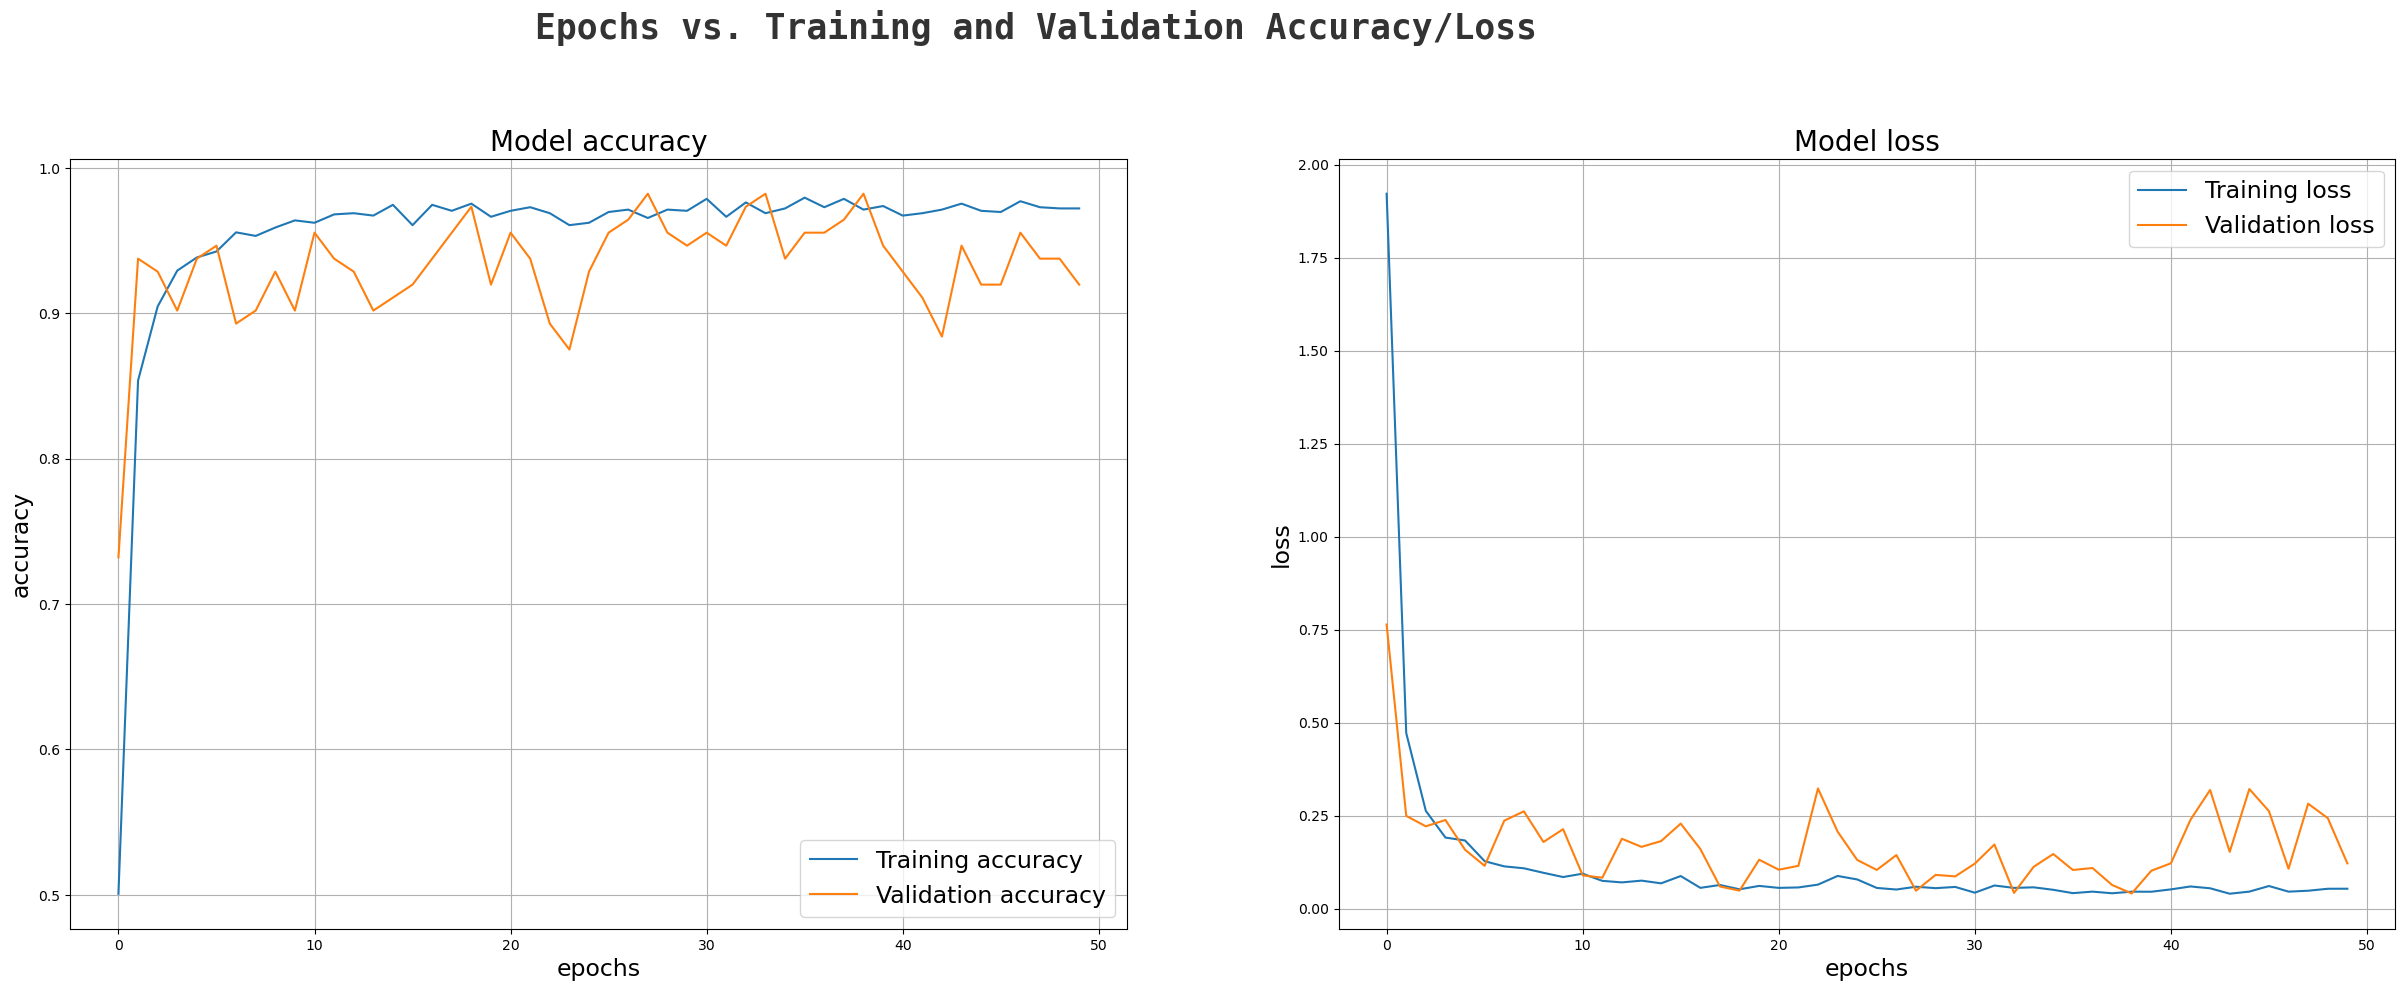

In [18]:
# define model
pretrained_model= tf.keras.applications.EfficientNetB0(
                   include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False

ef_model = Sequential()
ef_model.add(tf.keras.Input(shape=(224, 224, 3))),
ef_model.add(data_augmentation)
ef_model.add(tf.keras.layers.Lambda(tf.keras.applications.efficientnet.preprocess_input, input_shape=(224,224, 3)))
ef_model.add(pretrained_model)
ef_model.add(Flatten())
ef_model.add(Dense(128, activation='relu'))
ef_model.add(Dense(512, activation='relu'))
ef_model.add(Dense(30, activation='softmax'))
# compile
ef_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# summary of model
ef_model.summary()

# train
epochs=50
history = ef_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# evaluate model
score = ef_model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# show accuracy , loss graph
plot_accuracy_loss()

### C) VGG19

80134624/80134624 [==============================] - 0s 0us/step
Number of layers in the base model:  23
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda_2 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
               

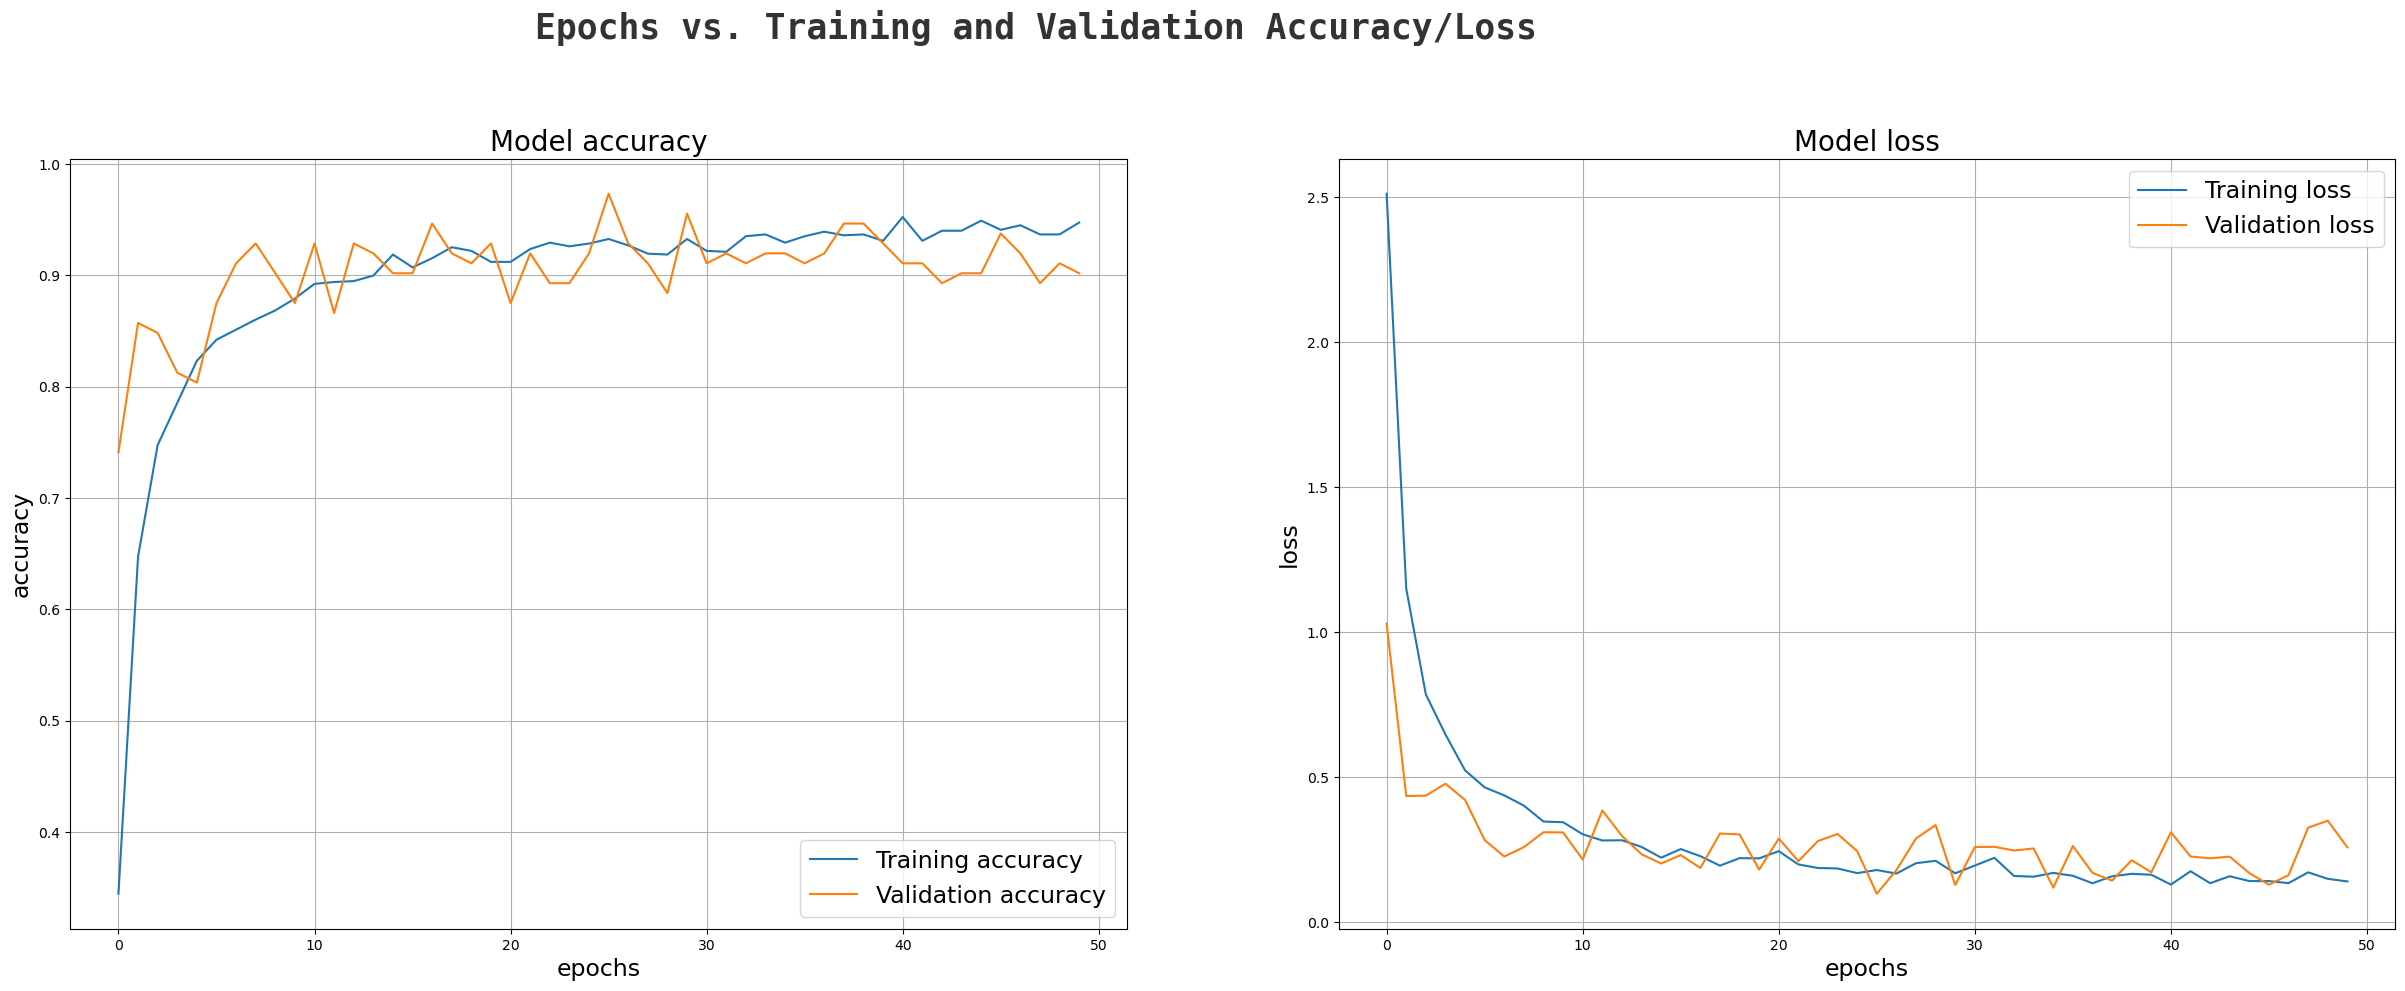

In [19]:
# define model
pretrained_model= tf.keras.applications.VGG19(
                   include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False
     
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pretrained_model.layers))
vgg_model = Sequential()
# vgg_model.add(tf.keras.Input(shape=(180, 180, 3)))
vgg_model.add(tf.keras.Input(shape=(224, 224, 3)))
vgg_model.add(data_augmentation)
vgg_model.add(tf.keras.layers.Lambda(lambda data: tf.keras.applications.vgg19.preprocess_input(tf.cast(data, tf.float32)), input_shape=(224,224, 3)))
vgg_model.add(pretrained_model)
vgg_model.add(Flatten())
vgg_model.add(Dense(128, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(30, activation='softmax'))


# compile
vgg_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
# # summary of model
vgg_model.summary()

# train
epochs=50
history = vgg_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# evaluate model
score = vgg_model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# show accuracy , loss graph
plot_accuracy_loss()

### D) Xception Net

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda_3 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               262272    
                                                                 
 dense_9 (Dense)             (None, 512)               66048     
                                                       

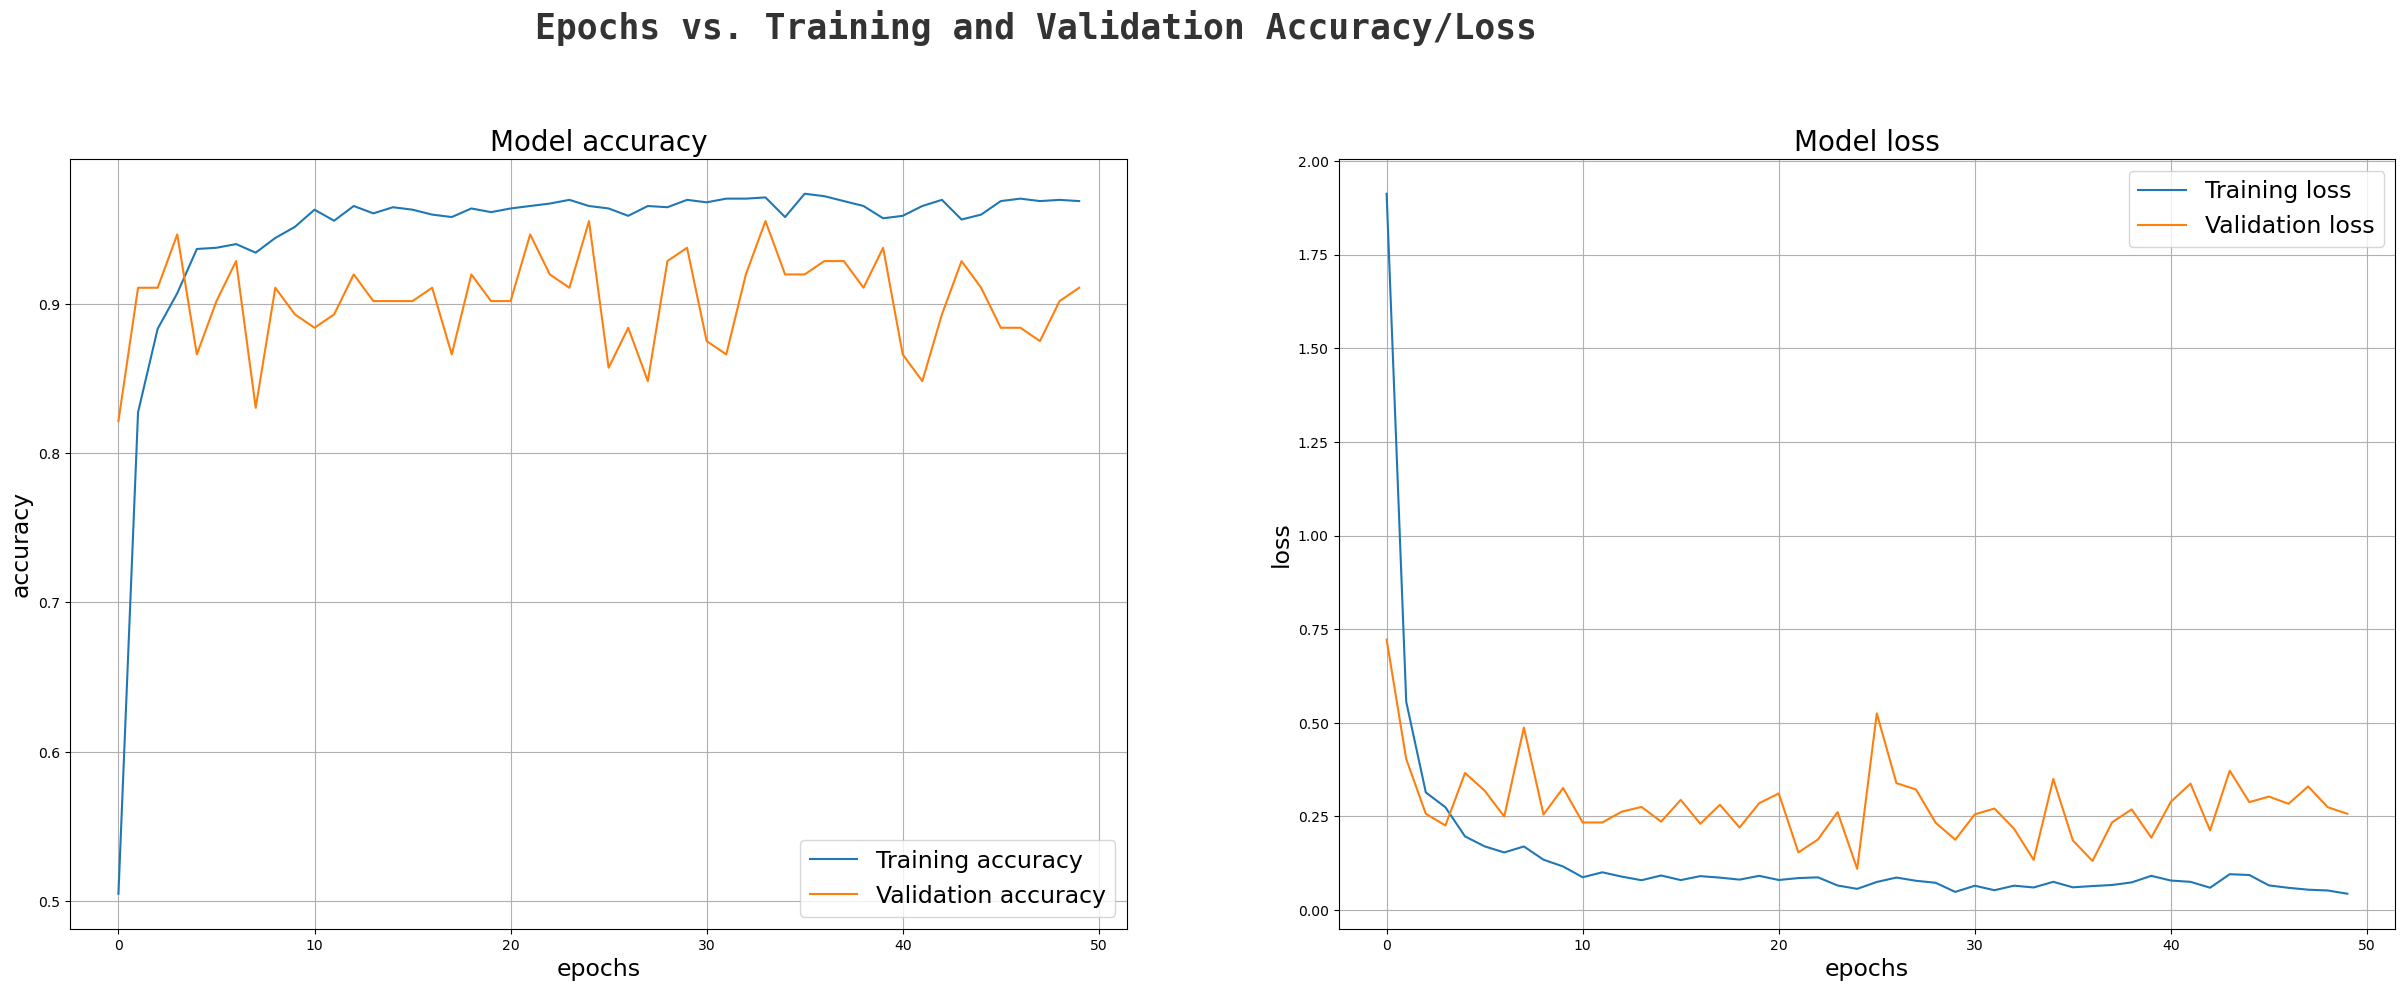

In [20]:
# define model
pretrained_model= tf.keras.applications.Xception(
                   include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False

xception_model = Sequential()
xception_model.add(tf.keras.Input(shape=(224, 224, 3))),
xception_model.add(data_augmentation)
xception_model.add(tf.keras.layers.Lambda(lambda data: tf.keras.applications.xception.preprocess_input(tf.cast(data, tf.float32)), input_shape=(224, 224, 3)))
xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(128, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
# xception_model.add(Dropout(0.5))
# xception_model.add(Dense(1024, activation='relu')
xception_model.add(Dense(30, activation='softmax'))

# compile
xception_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# summary of model
xception_model.summary()

# train
epochs=50
history = xception_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

#evaluate model
score = xception_model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# show accuracy , loss graph
plot_accuracy_loss()

### E) DenseNet201

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda_4 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 densenet201 (Functional)    (None, 1920)              18321984  
                                                                 
 flatten_4 (Flatten)         (None, 1920)              0         
                                                                 
 dense_11 (Dense)            (None, 128)               245888    
                                                                 
 dense_12 (Dense)            (None, 512)               66048     
                                                       

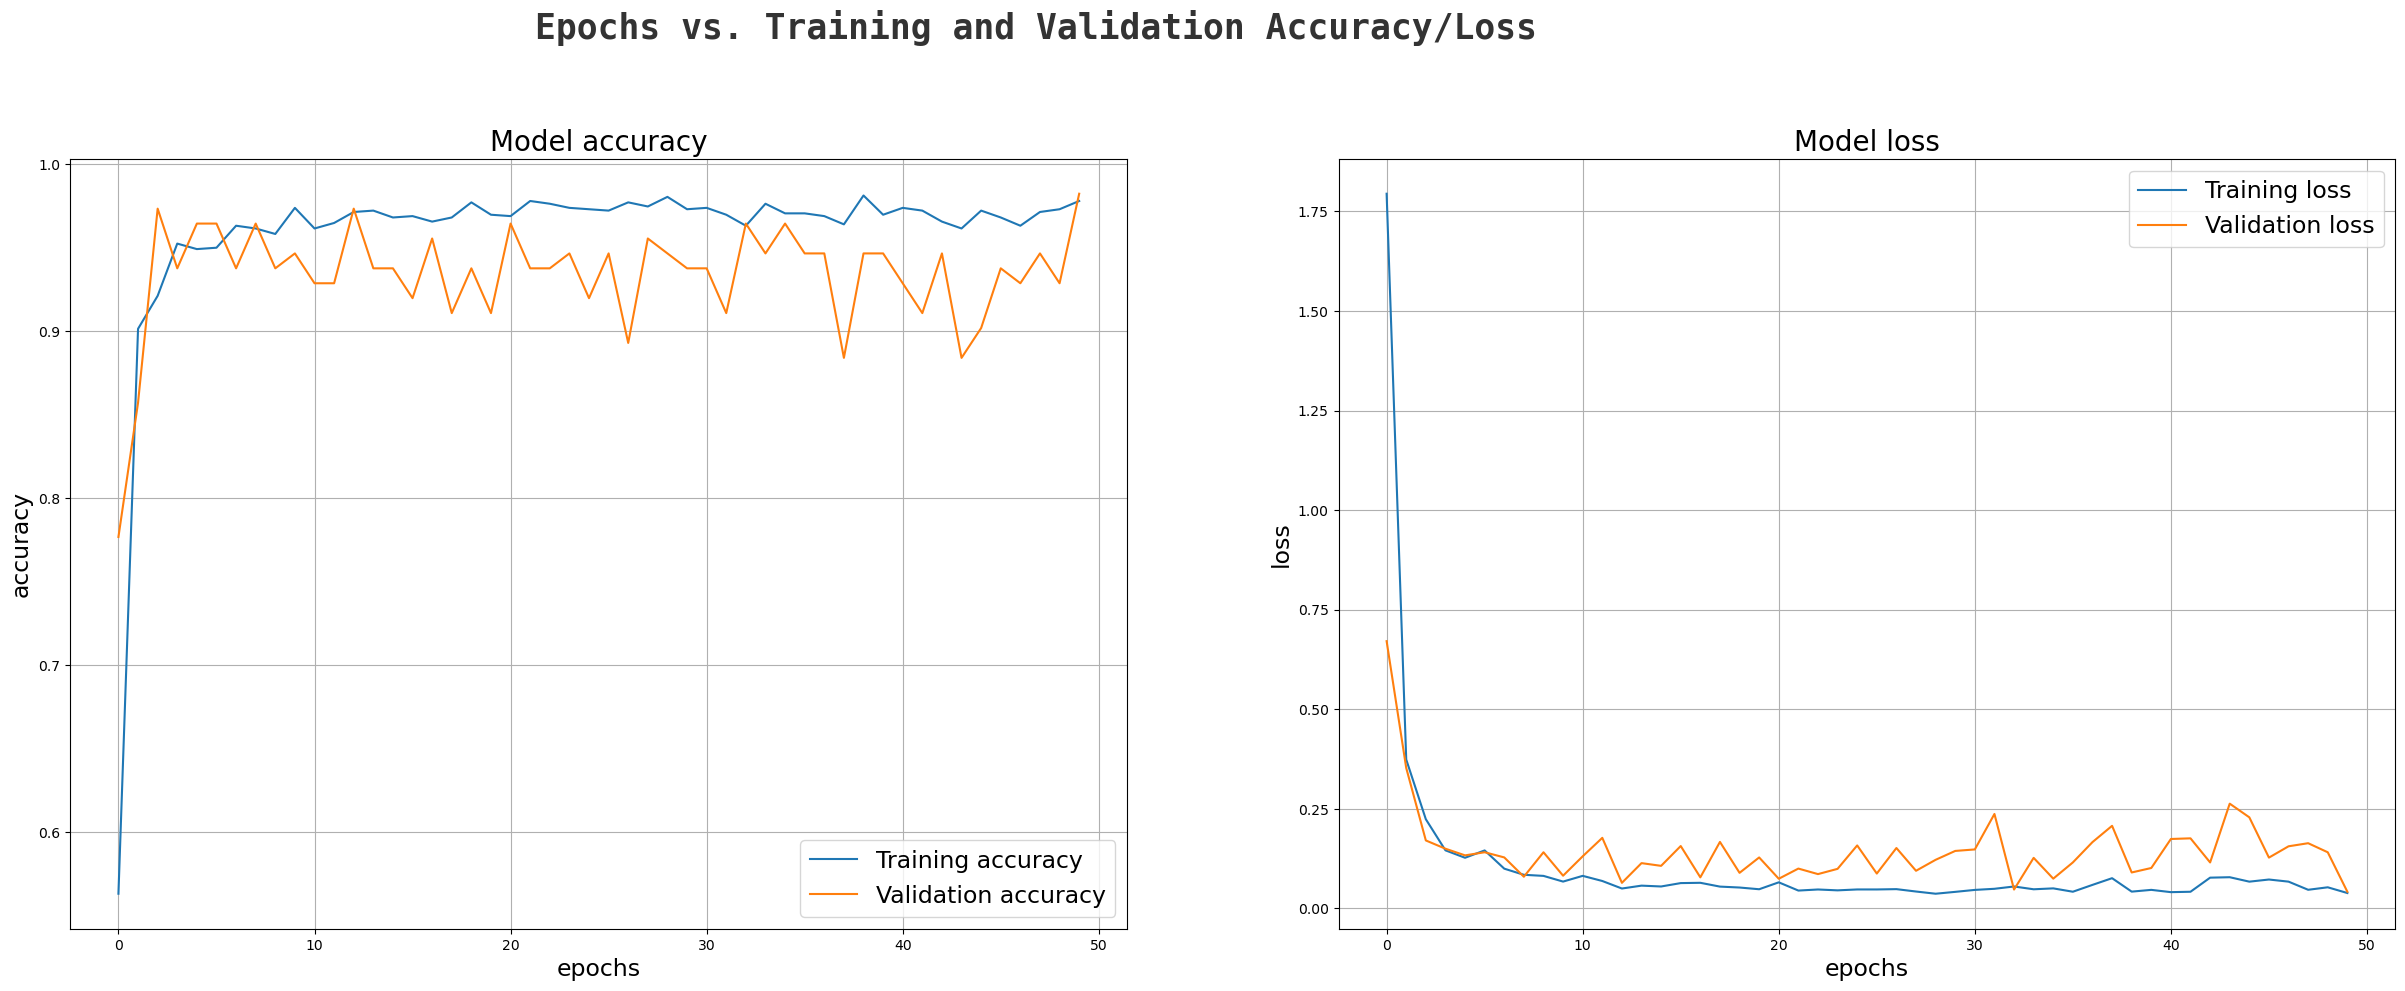

In [21]:
# define model
pretrained_model= tf.keras.applications.DenseNet201(
                   include_top=False,
                   input_shape=(224,224,3),
                   pooling='avg',
                   weights='imagenet')
for layer in pretrained_model.layers:
    layer.trainable=False

densenet_model = Sequential()
densenet_model.add(tf.keras.Input(shape=(224, 224, 3))),
densenet_model.add(data_augmentation)
densenet_model.add(tf.keras.layers.Lambda(tf.keras.applications.densenet.preprocess_input, input_shape=(224, 224, 3)))
densenet_model.add(pretrained_model)
densenet_model.add(Flatten())
densenet_model.add(Dense(128, activation='relu'))
densenet_model.add(Dense(512, activation='relu'))
densenet_model.add(Dense(30, activation='softmax'))
# compile
densenet_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# summary of model
densenet_model.summary()

# train
epochs=50
history = densenet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

# evaluate model
score = densenet_model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# show accuracy , loss graph
plot_accuracy_loss()

In [58]:
# function to get actual labels and predicted labels on test_ds
def get_actual_predicted_labels(dataset):
    
    """
        Create a list of actual ground truth values and the predictions from the model.

        Args:
          dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

        Return:
          Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in test_ds.unbatch()]
    predicted = ef_model.predict(test_ds)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)
    
    return actual, predicted

# confusion matrix
def plot_confusion_matrix(actual, predicted, labels, ds_type): 
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(40, 20)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)
    
# function to get class_names in test_ds
def get_sorted_class_names(ds):
    ## ds is Tensorflow dataset
    class_names = ds.class_names
    names = [int(name[5:]) for name in class_names]
    return sorted(names)

In [59]:
# test_class_names = get_sorted_class_names(test_ds)
test_class_names = get_sorted_class_names(test_ds)
actual, predicted = get_actual_predicted_labels(test_ds)
# actual, predicted = get_actual_predicted_labels(val_ds)

10/10 [==============================] - 2s 230ms/step


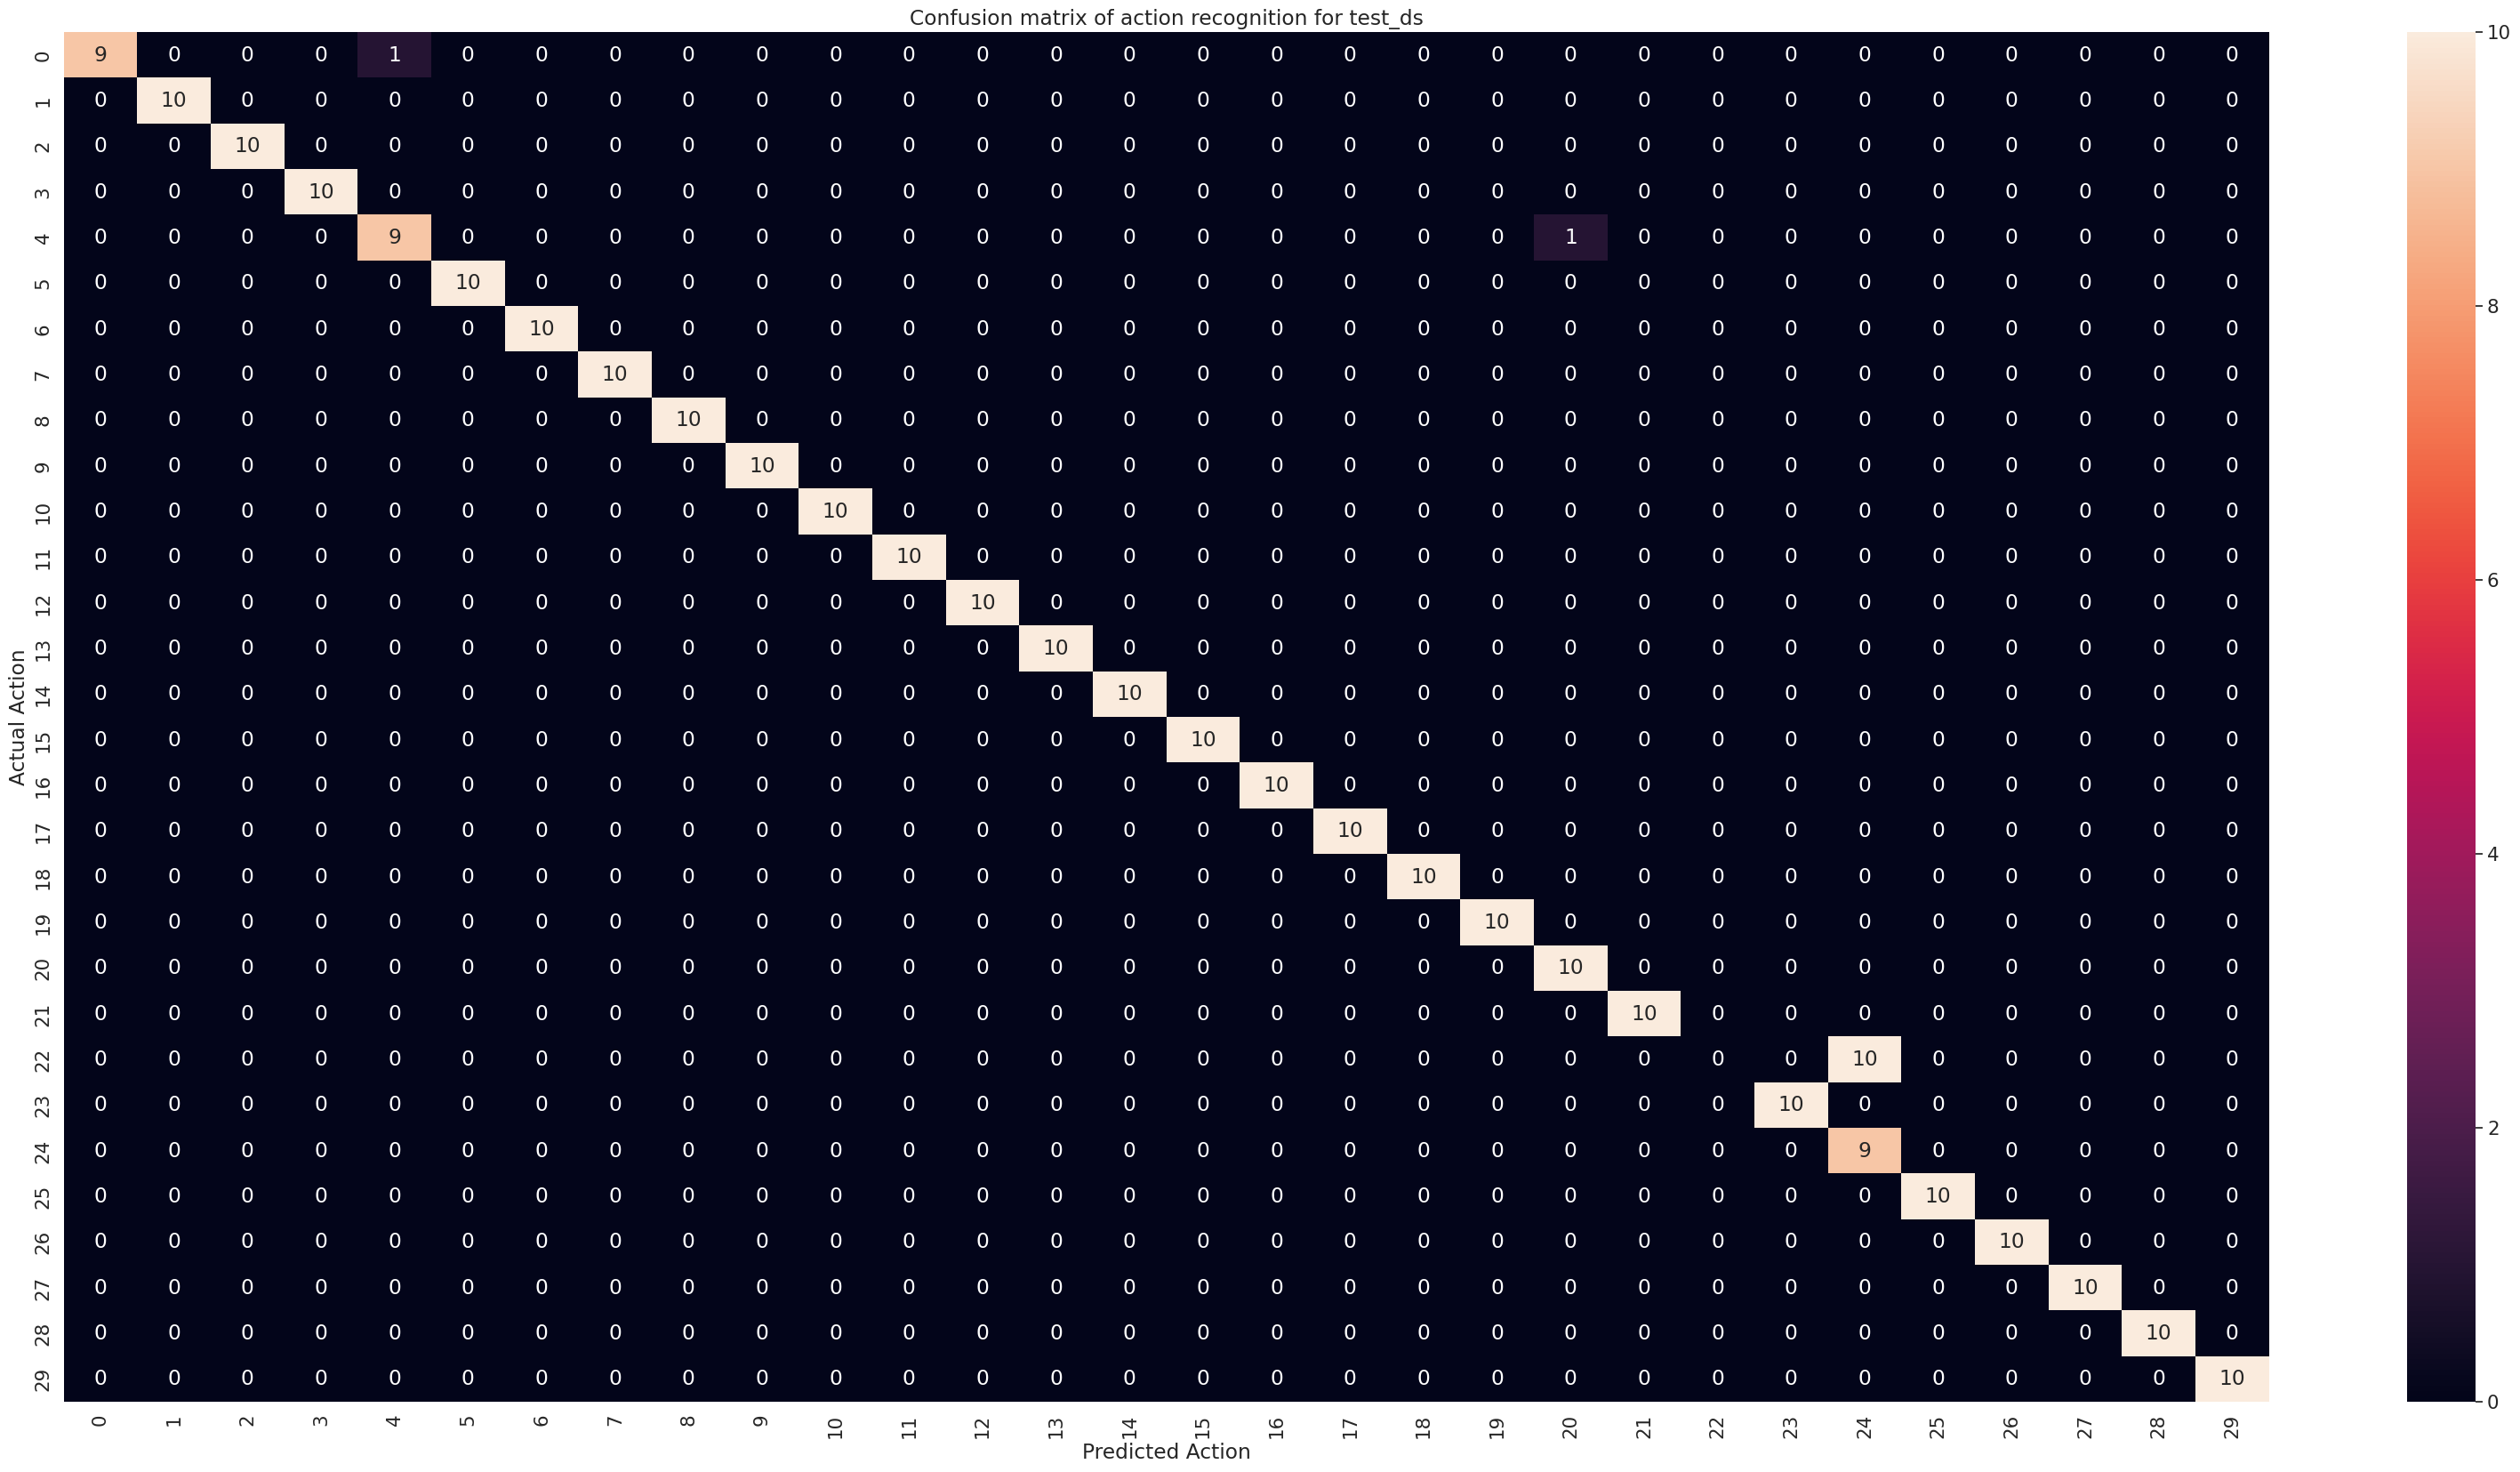

In [60]:
plot_confusion_matrix(actual, predicted, test_class_names, 'test_ds')

In [61]:
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10
           3       1.00      1.00      1.00        10
           4       0.90      0.90      0.90        10
           5       1.00      1.00      1.00        10
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        10
          11       1.00      1.00      1.00        10
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10
          17       1.00    

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
densenet_model.save('plantspecies_ef_model.h5')

In [ ]:
!tar -czf plantSpeciesModel.tar.gz '/kaggle/working/'

from IPython.display import FileLink

FileLink(r'plantSpeciesModel.tar.gz')